# Deep Neural Network Visualization - Create Models
<hr>

# 0. Setup Libraries

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import keras

Using TensorFlow backend.


In [16]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.models import model_from_json

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
import numpy as np
import scipy
import re

In [7]:
from PIL import Image

In [8]:
import codecs
import json 

### Set Current Path

In [9]:
current_path = os.getcwd()
os.chdir(current_path)

# 1. Setup Training / Test Data

### A. Load MNIST Dataset

In [10]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### X data (features)

In [11]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


### Y data (labels)

In [12]:
num_classes = 10

# Convert y_train and y_test to categorical datatypes
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# 2. Construct Model

### i. Setup Create New Model Function

In [23]:
def create_new_model(input_dim=784, hidden_dim=512, dropout_rate=0.2, summary=True, dropout=True):
    
    
    # Initialize model
    model = Sequential()
    
    # Input(24x24x1)
    model.add(Dense(hidden_dim, activation='relu', input_shape=(input_dim,)))

  
    # CONV (24x24x8)
    model.add(Conv2D(24, 24, 8))
    
    
    # RELU (24x24x8)
    model.add(Activation('relu'))
    
    
    # POOL (12x12x8)
    model.add(MaxPooling2D(poolsize=(12, 12, 8)))
    
    # CONV (12x12x16)
    model.add(Conv2D(12, 12, 16))
    
    # RELU (12x12x16)
    model.add(Activation('relu'))
    
    
    # POOL (4x4x16)
    model.add(MaxPooling2D(poolsize=(12, 12, 8)))
    
    # FC (1x1x10)
    model.add(Dropout(0.25))
    model.add(Flatten())
    
    # SOFTMAX (1x1x10)
    model.add(Activation('softmax'))
    
    
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    
    if summary: print(model.summary())
    
    return model

## A. Generate Models

In [24]:
new_model_num = 1

models = {}

for model_num in range(1, new_model_num+1):
    new_model_name = "model_{}".format(model_num)
    new_model = create_new_model()
    models[new_model_name] = {"model_t0" : new_model}

/Users/mliuzzolino/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (24, 8))`


ValueError: Input 0 is incompatible with layer conv2d_3: expected ndim=4, found ndim=2

# 3. Train Models

### i. Setup Train Parameters

In [13]:
batch_size = 128

## A. Train

In [14]:
time_steps = 15
num_training_samples = 10000
num_test_samples = 1000

    
for model_name, items in models.items():
    
    # Set current model
    model = items["model_t0"]
    
    # Get layer 1 weights from initiale model
    layer_1_initial_weights = np.array(model.layers[0].get_weights()[0]).flatten()
        
    # Declare time series list to store layer 1 weights at each epoch step
    model_weights_time_series = [layer_1_initial_weights.tolist()]
    
    
    # Increment by 1 epoch each loop, store weight from layer 1 of each iteration of the model
    for time_step in range(1, time_steps+1):
        
        # Randomly draw *num_training_samples* from x_test, y_test
        random_training_indices = [np.random.randint(0, 60000) for _ in range(num_training_samples)]
        random_test_indices = [np.random.randint(0, 10000) for _ in range(num_test_samples)]
        
        # Set stubbed training / testing data
        x_train_stubb = x_train[random_training_indices]
        y_train_stubb = y_train[random_training_indices]
        x_test_stubb = x_test[random_test_indices]
        y_test_stubb = y_test[random_test_indices]
        
        # Set verbosity
        verbosity = 1 if time_steps < 10 else 0
        
        # Fit the model
        model.fit(x_train_stubb, y_train_stubb, epochs=1, batch_size=batch_size, validation_data=(x_test_stubb, y_test_stubb), verbose=verbosity)
        
        # Get the layer 1 weights
        layer_1_weights = np.array(model.layers[0].get_weights()[0]).flatten()
       
        # Store layer 1 weights
        model_weights_time_series.append(layer_1_weights.tolist())
        
    
   
    
    # Store model weights time sequence
    models[model_name]["epochs"] = model_weights_time_series
    
    # Store final model
    models[model_name]["model_tf"] = model


## Plot the weight distributions

In [54]:
import pylab as P

def _blob(x,y,area,colour):
    """
    Draws a square-shaped blob with the given area (< 1) at
    the given coordinates.
    """
    hs = np.sqrt(area) / 2
    xcorners = np.array([x - hs, x + hs, x + hs, x - hs])
    ycorners = np.array([y - hs, y - hs, y + hs, y + hs])
    P.fill(xcorners, ycorners, colour, edgecolor=colour)

def hinton(pre_W, maxWeight=None):
    
    W = np.array(pre_W)
    
    W = W.reshape(10, 10)
    """
    Draws a Hinton diagram for visualizing a weight matrix. 
    Temporarily disables matplotlib interactive mode if it is on, 
    otherwise this takes forever.
    """
    reenable = False
    if P.isinteractive():
        P.ioff()
    P.clf()
    height, width = W.shape
    if not maxWeight:
        maxWeight = 2**np.ceil(np.log(np.max(np.abs(W)))/np.log(2))
        
    P.fill(np.array([0,width,width,0]),np.array([0,0,height,height]),'gray')
    P.axis('off')
    P.axis('equal')
    for x in range(width):
        for y in range(height):
            _x = x+1
            _y = y+1
            w = W[y,x]
            if w > 0:
                _blob(_x - 0.5, height - _y + 0.5, min(1,w/maxWeight),'white')
            elif w < 0:
                _blob(_x - 0.5, height - _y + 0.5, min(1,-w/maxWeight),'black')
    if reenable:
        P.ion()
    P.show()

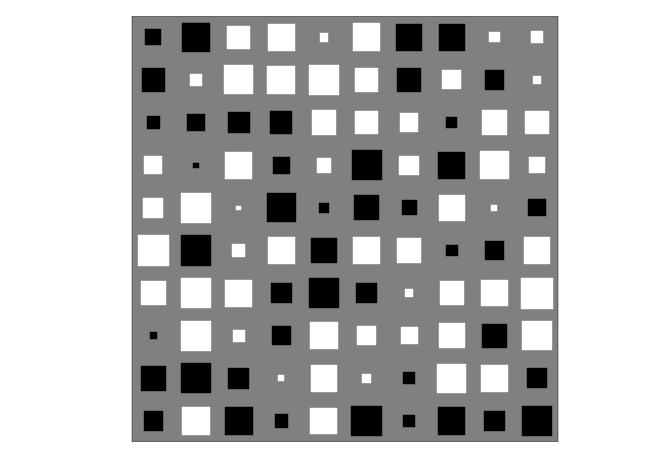

In [55]:
plot_number = 1

layer_1 = items["epochs"][0][:100]
hinton(layer_1)
# for model_name, items in models.items():
#     for time_step, layer in enumerate(items["epochs"]):
#         test_layer = [layer]
#         if time_step >= plot_number:
#             break
        
# # Plot the layer weights
# hinton(test_layer)
        
    

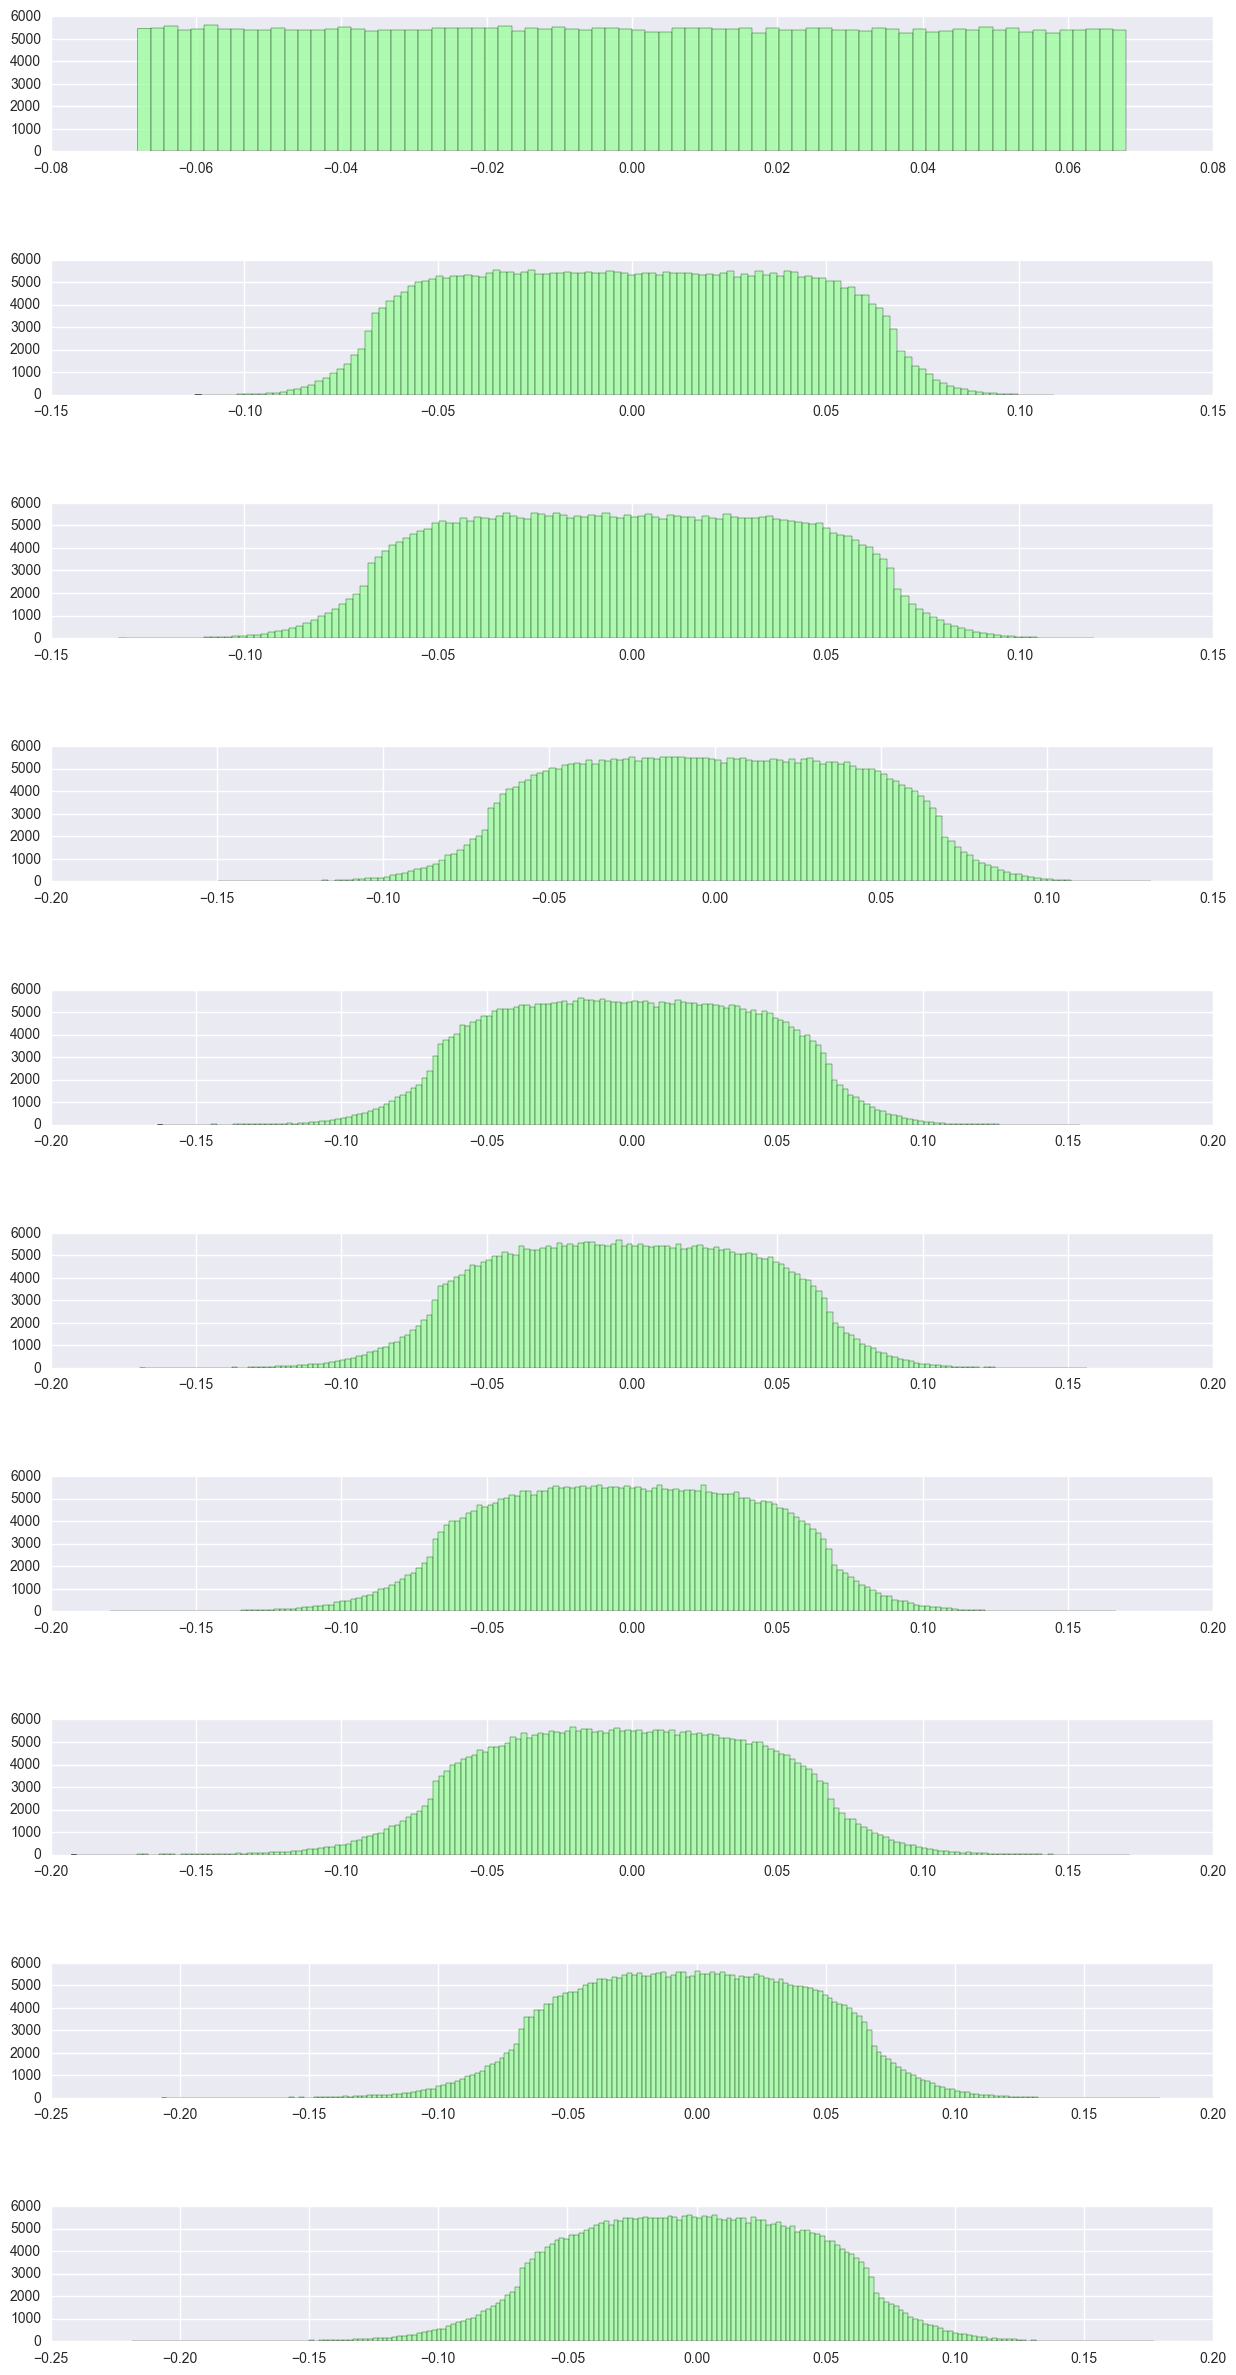

In [15]:
plot_number = 10

# Setup figure
fig = plt.figure()

for model_name, items in models.items():
    for time_step, layer in enumerate(items["epochs"]):
        
        if time_step >= plot_number:
            break
        
        # Setup the axis
        ax = fig.add_subplot(plot_number, 1, time_step+1)
        
        # Plot the layer weights
        sns.distplot(layer, bins='auto', kde=False, rug=False, ax=ax, color="#99ff99", hist_kws=dict(alpha=0.75))
        
    # Figure attributes
    fig.subplots_adjust(hspace=0.8)
    fig.set_figheight(30)
    fig.set_figwidth(15)
    
    # Show the plot
    plt.show()  

# 4. Score Models

In [16]:
for model_name, items in models.items():
    print(model_name)
    model = items["model_tf"]
    test_score = model.evaluate(x_test, y_test, verbose=0)
    train_score = model.evaluate(x_train, y_train, verbose=0)
    models[model_name]["score"] = {"test loss" : test_score[0], 
                                   "test accuracy" : test_score[1],
                                   "train accuracy" : train_score[1]}
    
    print('Test loss: {}'.format(test_score[0]))
    
    print('Train accuracy: {}'.format(train_score[1]))
    print('Test accuracy: {}'.format(test_score[1]))
    print("\n")

model_1
Test loss: 0.09473122883616016
Train accuracy: 0.9844333333333334
Test accuracy: 0.9734




## Extract Weight Matrices from Model

#### weights to json function

In [17]:
def weights_to_json(data, file_name):
    # Set file path
    file_path = "json_files/{}.json".format(file_name)
    
    # Dump json data
    json.dump(data, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)


### Format and write data

In [18]:
for model_name, items in models.items():
    # Define the edata to write
    write_data = { model_name : items["epochs"] }
    
    # write to json
    weights_to_json(write_data, model_name)


## Save Trained Model and Weights to file

In [19]:
for model_name, items in models.items():

    # Set model
    model = items["model_tf"]

    # serialize model to JSON
    model_json = model.to_json()

    # Write model to file
    outfile_name = "models/{}.json".format(model_name)
    with open(outfile_name, "w") as json_file:
        json_file.write(model_json)

    # Serialize weights to HDF5 and save
    model.save_weights("models/{}_weights.h5".format(model_name))

    print("Saved {} to disk.".format(model_name))

Saved model_1 to disk.


# Appendix A: References

## Keras
- https://keras.io/getting-started/sequential-model-guide/
- https://keras.io/models/sequential/#sequential-model-methods

## Numpy and Images
- http://scikit-image.org/docs/dev/user_guide/numpy_images.html
- astropy, but useful: http://prancer.physics.louisville.edu/astrowiki/index.php/Image_processing_with_Python_and_SciPy
- https://www.safaribooksonline.com/library/view/programming-computer-vision/9781449341916/ch01.html

## Resizing images for NN processing
- https://datascience.stackexchange.com/questions/5224/how-to-prepare-images-for-neural-network

## Database
- MongoDB: https://realpython.com/blog/python/introduction-to-mongodb-and-python/

## Saving Net One Step at a Time
- https://github.com/fchollet/keras/issues/85

## Dict to JSON
- http://robotfantastic.org/serializing-python-data-to-json-some-edge-cases.html

## Batch Size Explained Well
- https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network

## Datasets

#### MIT Places
The compressed file of resized 256*256 images, containing train set and validation set of Places 205.
http://data.csail.mit.edu/places/places205/imagesPlaces205_resize.tar.gz